<a href="https://colab.research.google.com/github/sramakrishnan247/jubilant-adventure/blob/main/COCODataLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import pickle
import numpy as np
import nltk
from PIL import Image
from pycocotools.coco import COCO
import random
import skimage.io as io
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import copy

#### Download Annotations

In [2]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2021-06-17 21:27:46--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.161.161
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.161.161|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  89.0MB/s    in 2.7s    

2021-06-17 21:27:49 (89.0 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [3]:
!unzip annotations_trainval2017.zip >/dev/null

In [4]:
annFile='./annotations/instances_val2017.json'

#### Download images

In [5]:
!wget http://images.cocodataset.org/zips/val2017.zip >/dev/null

--2021-06-17 21:27:57--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.170.33
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.170.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  54.6MB/s    in 14s     

2021-06-17 21:28:11 (55.6 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [6]:
!unzip val2017.zip >/dev/null

### COCO Dataloader

In [7]:
class CocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, json, transform=None,root=None, ):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            json: coco annotation file 
            root: image directory
            transform: image transformer.
        """
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.cats = self.coco.loadCats(self.coco.getCatIds())
        self.transform = transform

    def __getitem__(self,label=0):
        """Returns one data pair (image and label)."""
        coco = self.coco

        choice = random.randint(0,1)

        if choice == 0:
            catIds = coco.getCatIds(catNms=['person'])
            label = 1.0
        else:
            catIds = coco.getCatIds(catNms=self.cats)
            label = 0.0

        imgIds = coco.getImgIds(catIds=catIds)

        invalid_image = True
        while invalid_image:
            rand_index = random.randint(0,len(imgIds)-1)
            image = coco.loadImgs(imgIds)[rand_index]

            #Load image from the disk
            path = os.path.join(self.root,image['file_name'])

            image = io.imread(path)

            #Ignore grayscale images
            if len(image.shape) == 3:
                invalid_image = False

        
        image = Image.fromarray(image)
        label = torch.tensor([label])


        if self.transform is not None:
            image =  self.transform(image)

        return image, label

    def __len__(self):
        return len(self.ids)


def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, target).
    Args:
        data: list of tuple (image, target). 
            - image: torch tensor of shape (3, 256, 256).
            - label: torch tensor 

    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        labels : torch tensor of shape (batch_size, label).
    """

    images, labels = zip(*data)

    #Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    #Merge labels (from tuple of 3D tensor to 4D tensor).
    labels = torch.stack(labels, 0)

    return images, labels

def coco_transforms():
    return transforms.Compose([transforms.Resize((256,256)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [8]:
coco = CocoDataset(annFile,transform=coco_transforms(),root='val2017')

loading annotations into memory...
Done (t=0.76s)
creating index...
index created!


In [9]:
# dataloader = torch.utils.data.DataLoader(dataset=coco,batch_size=1,collate_fn=collate_fn,num_workers=1)
dataloader = torch.utils.data.DataLoader(dataset=coco,batch_size=8)

In [10]:
x,y = next(iter(dataloader))

In [11]:
x.shape

torch.Size([8, 3, 256, 256])

In [12]:
y.shape

torch.Size([8, 1])

In [13]:
# for i in range(len(dataloader)//8):
#     xx, yy = next(iter(dataloader))
#     print(i,xx.shape,yy.shape)

0 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
1 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
2 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
3 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
4 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
5 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
6 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
7 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
8 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
9 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
10 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
11 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
12 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
13 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
14 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
15 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
16 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
17 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
18 torch.Size([8, 3, 256, 256]) torch.Size([8, 1])
19 torch.Size([8, 3, 256, 256]) torch.Siz

### Visualize images

[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]


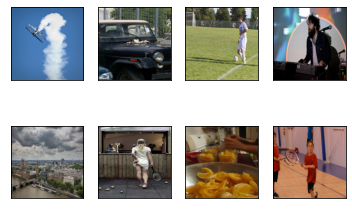

In [14]:
def show(imgs,labels):
    print([label.item() for label in labels])
    if not isinstance(imgs, list):
        imgs = [imgs]
    ncols = 4
    nrows = len(imgs)//ncols
    fix, axs = plt.subplots(nrows,ncols,squeeze=False)
    r,c = 0,0

    inv_normalize = transforms.Normalize(
                    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std=[1/0.229, 1/0.224, 1/0.225]
        )

    for i, img in enumerate(imgs):
        img = inv_normalize(img)
        img = img.detach()
        img = F.to_pil_image(img)
        axs[r, c].imshow(np.asarray(img))
        axs[r, c].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        c += 1
        if c % ncols == 0:
            r += 1
            c = 0
    

show([image for image in x],y)

### Load pretrained Resnet

In [15]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet152', pretrained=True)
# model.eval()
best_model_wts = copy.deepcopy(model.state_dict())

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [16]:
#change final out for fine-tuning
model.fc = torch.nn.Sequential(torch.nn.Linear(model.fc.in_features,1),torch.nn.Sigmoid())


In [30]:
#Set hyperparameters for training
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
num_epochs = 100
model = model.train()
device = 'cuda'
model = model.to(device)

for epoch in range(num_epochs):
    # for i in range(10):
    running_loss = 0
    count = 0
    for i in range(len(dataloader)//8):
    # for i in range(100):
        count += 1
        inputs, labels = next(iter(dataloader))

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(inputs)
        # print(output,type(output),output.dtype)
        # print(labels,type(labels),labels.dtype)
        loss = criterion(output,labels)

        loss.backward()
        optimizer.step()

        running_loss += loss

    print(epoch, running_loss/count)




0 tensor(0.6933, device='cuda:0', grad_fn=<DivBackward0>)
1 tensor(0.6931, device='cuda:0', grad_fn=<DivBackward0>)
2 tensor(0.6931, device='cuda:0', grad_fn=<DivBackward0>)
3 tensor(0.6931, device='cuda:0', grad_fn=<DivBackward0>)
4 tensor(0.6930, device='cuda:0', grad_fn=<DivBackward0>)
5 tensor(0.6926, device='cuda:0', grad_fn=<DivBackward0>)
6 tensor(0.6930, device='cuda:0', grad_fn=<DivBackward0>)
7 tensor(0.6929, device='cuda:0', grad_fn=<DivBackward0>)
8 tensor(0.6930, device='cuda:0', grad_fn=<DivBackward0>)
9 tensor(0.6929, device='cuda:0', grad_fn=<DivBackward0>)
10 tensor(0.6925, device='cuda:0', grad_fn=<DivBackward0>)
11 tensor(0.6924, device='cuda:0', grad_fn=<DivBackward0>)
12 tensor(0.6935, device='cuda:0', grad_fn=<DivBackward0>)
13 tensor(0.6921, device='cuda:0', grad_fn=<DivBackward0>)
14 tensor(0.6929, device='cuda:0', grad_fn=<DivBackward0>)
15 tensor(0.6928, device='cuda:0', grad_fn=<DivBackward0>)
16 tensor(0.6926, device='cuda:0', grad_fn=<DivBackward0>)
17 tens